# Исследование сервиса аренды самокатов GoFast.

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) —  50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Цель проекта - проверить гипотезы:**
- Пользователи с подпиской тратят больше времени на поездки.
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Провести тест для проверки данной гипотизы.

**Ход исследования**

Данные о пользователях представлены в файлах /datasets/users_go.csv, /datasets/rides_go.csv, /datasets/subscriptions_go.csv. О данных в файле информация не представлена, поэтому необходимо провести обзор данных. Нужно проверить данных на ошибки о оценить их влияние на исследование, и их исправить. После обработки данных приступить к выпролнению рассчетов, объединению таблиц, построению графиков и пр.

Таким образом, исследование пройдёт в 5 этапов:
- предобработка данных;
- исследовательский анализ данных;
- объединение данных;
- подсчет выручки;
- проверка гипотез;

### Загрузка данных

#### Импортируем необходимые библиотеки

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

#### Откроем файлы с датафреймами

In [10]:
user_go = pd.read_csv('users_go.csv')
rides_go = pd.read_csv('rides_go.csv', parse_dates=['date'])
sub_go = pd.read_csv('subscriptions_go.csv')

In [11]:
#Устанавливаем формат отображения чисел с плавающей запятой (float) в два знака.
#Это позволяет отобразить числа с ограниченным числом десятичных знаков для более удобного чтения
pd.options.display.float_format = '{:.2f}'.format
# Создадим функцию для просмотра информации о датафреймах
def info_dt(row):
    """
    Данная функция выводит первичную информацию о датафреме
    """
    print('Вывод первых 20-ти строчек')
    
    print(row.head(20))
    print("\n") 
    print('Вывод информации о датафрейме')
    
    row.info()
    print("\n") 
    print('Представление о данных в числах')
    
    print(row.describe())

#### Рассмотрим каждый датафрейм по отдельности

Датафрейм с пользователями

In [14]:
info_dt(user_go)

Вывод первых 20-ти строчек
    user_id        name  age            city subscription_type
0         1        Кира   22          Тюмень             ultra
1         2   Станислав   31            Омск             ultra
2         3     Алексей   20          Москва             ultra
3         4  Константин   26  Ростов-на-Дону             ultra
4         5       Адель   28            Омск             ultra
5         6      Регина   25       Краснодар             ultra
6         7       Игорь   23            Омск             ultra
7         8        Юрий   23       Краснодар             ultra
8         9          Ян   21       Пятигорск             ultra
9        10     Валерий   18    Екатеринбург             ultra
10       11       Агата   31       Краснодар             ultra
11       12        Марк   27          Тюмень             ultra
12       13         Ева   24       Краснодар             ultra
13       14    Антонина   18       Пятигорск             ultra
14       15     Валерия   24

Вывод по датафрейму: заголовки столбцов соответствует нормальному стилю, таблица имеет корректный тип данных у столбцов, отсутствуют пропуски в значениях.

Датафрейм с поездками

In [17]:
info_dt(rides_go)

Вывод первых 20-ти строчек
    user_id  distance  duration       date
0         1   4409.92     25.60 2021-01-01
1         1   2617.59     15.82 2021-01-18
2         1    754.16      6.23 2021-04-20
3         1   2694.78     18.51 2021-08-11
4         1   4028.69     26.27 2021-08-28
5         1   2770.89     16.65 2021-10-09
6         1   3039.02     14.93 2021-10-19
7         1   2842.12     23.12 2021-11-06
8         1   3412.69     15.24 2021-11-14
9         1    748.69     15.04 2021-11-22
10        1   4031.02     17.67 2021-12-14
11        1   2720.61      9.53 2021-12-22
12        2   3105.09     24.31 2021-03-15
13        2   3053.52     11.54 2021-03-18
14        2   4029.12     25.11 2021-03-23
15        2   2805.79     20.65 2021-04-08
16        2   3358.60     18.40 2021-04-13
17        2   3255.34     13.85 2021-06-20
18        2   3942.82     20.14 2021-07-02
19        2   2837.91     26.03 2021-07-18


Вывод информации о датафрейме
<class 'pandas.core.frame.DataFrame'>


Вывод по датафрейму: заголовки столбцов соответствует нормальному стилю, столбцы имеют корректный тип данных, отсутствуют пропуски в значениях.

Датафрейм с подписками 

In [20]:
info_dt(sub_go)

Вывод первых 20-ти строчек
  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199


Вывод информации о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Представление о данных в числах
       minute_price  start_ride_price  subscription_fee
count          2.00              2.00              2.00
mean           7.00             25.00             99.50
std            1.41             35.36            140.71
min            6.00              0.0

Вывод по датафрейму: все правильно.

**Выводы**: 
- все таблицы имееют нормальный стиль заголовков;
- пропуски значений отсутствуют;
- в таблицах отсутствуют нереалистичные значения.

### Шаг 2. Предобработка данных

#### Создим новый столбец с номером месяца на основе столбца date.

In [25]:
# Проверим, за какой период собраны данные
print(rides_go['date'].min())
print(rides_go['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


Данные представлены за 1 год.

In [27]:
rides_go['month'] = rides_go['date'].dt.month
# Проверяем
rides_go.head(10)

,user_id,distance,duration,date,month
0,1,4409.92,25.60,2021-01-01,1
1,1,2617.59,15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,2694.78,18.51,2021-08-11,8
4,1,4028.69,26.27,2021-08-28,8
5,1,2770.89,16.65,2021-10-09,10
6,1,3039.02,14.93,2021-10-19,10
7,1,2842.12,23.12,2021-11-06,11
8,1,3412.69,15.24,2021-11-14,11
9,1,748.69,15.04,2021-11-22,11


#### Проверим наличие дубликатов в датафреймах rides_go и user_go

In [29]:
user_go.duplicated().sum()

31

In [30]:
# Удалим дубликаты
user_go.drop_duplicates(inplace=True)
# Проверим
user_go.duplicated().sum()

0

In [31]:
# Проверим на наличие неявных дубликатов
user_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Дубликаты не обнаружены

In [33]:
 rides_go.duplicated().sum()

0

Дубликаты не обнаружены

**Вывод**:
- изменили тип данных столбца date таблице rides_go на корректный;
- добавили новый столбец month в датафрейм rides_go;
- удалили и проверили наличие дубликатов.

### Шаг 3. Исследовательский анализ данных

#### Частота встречаемости городов

In [38]:
print(user_go['city'].value_counts()) 
print("\n")
print('Соотношение  встречаемости города к общиму количеству')
user_go['city'].value_counts() / user_go['city'].value_counts().sum()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


Соотношение  встречаемости города к общиму количеству


city
Пятигорск        0.14
Екатеринбург     0.13
Ростов-на-Дону   0.13
Краснодар        0.13
Сочи             0.12
Омск             0.12
Тюмень           0.12
Москва           0.11
Name: count, dtype: float64

Приложением больше всего пользуются в Пятигорске и Екатеринбугре. Меньше всего в Москве. Приложение пользуется примерно равным спросом в каждом городе в процентном соотношении.

<Axes: title={'center': 'Распределение пользователей по городам'}, ylabel='city'>

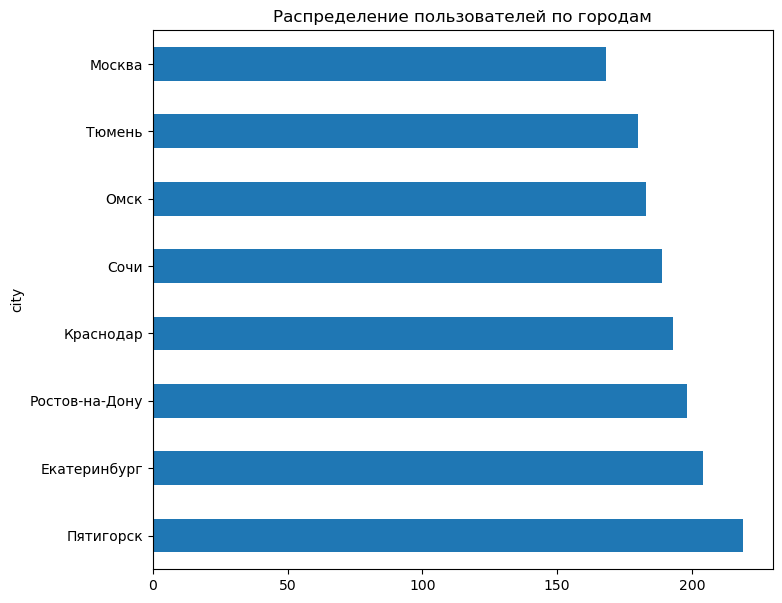

In [40]:
# Построим круговою диаграмму для визуализации данных
user_go['city'].value_counts().plot.barh(
                                    title = 'Распределение пользователей по городам', 
                                    figsize=(8, 7))

#### Соотношение пользователей с подпиской и без подписки.

In [42]:
sub_corr = user_go['subscription_type'].value_counts() / user_go['subscription_type'].count()
print(user_go['subscription_type'].value_counts())
sub_corr

subscription_type
free     835
ultra    699
Name: count, dtype: int64


subscription_type
free    0.54
ultra   0.46
Name: count, dtype: float64

Пользователей без подписки больше.

<Axes: title={'center': 'Соотношение пользователей с подпиской и без подписки'}, ylabel='count'>

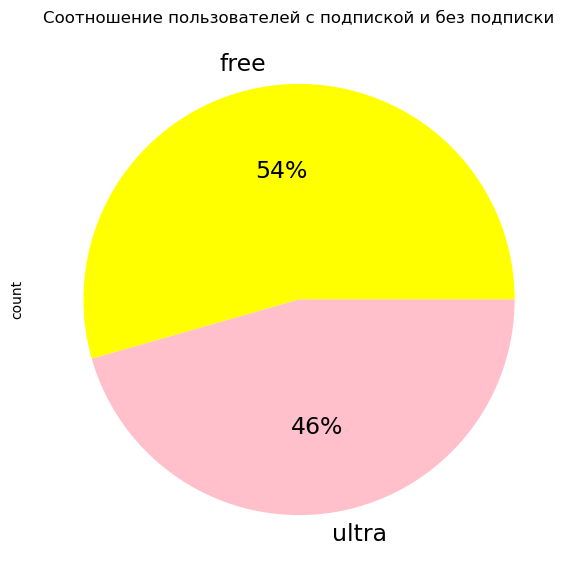

In [44]:
# Построим круговою диаграмму для визуализации данных
sub_corr.plot(kind = 'pie', autopct = '%1.0f%%',title = 'Соотношение пользователей с подпиской и без подписки', 
              colors=['yellow', 'pink'],
              textprops={'fontsize': 17}, 
              figsize=(8, 7))

#### Возраст пользователей

In [46]:
user_go['age'].describe()

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

Text(0, 0.5, 'Частота')

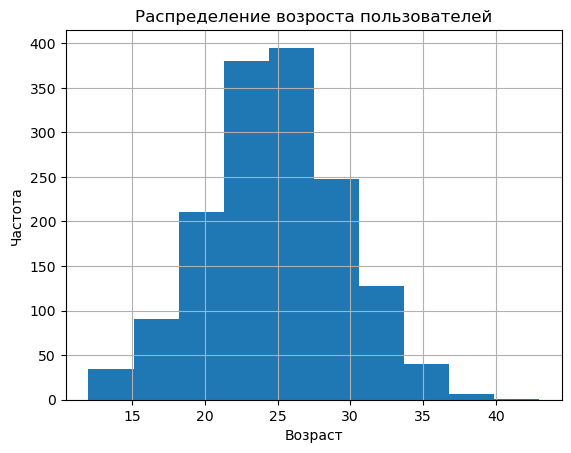

In [47]:
user_go['age'].hist()
plt.title('Распределение возроста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')

Самый младший пользователь - 12 лет. Самый старший пользователь - 43 года. Средний возраст - 25 лет. Больше всего пользователей возраста 21 - 27 лет. Клиенты возрастом после 37 лет встречаются редко.

#### Расстояние, которое пользователь преодолел за одну поездку

In [50]:
# Самые короткие поездки
rides_go.sort_values('distance').head(10)

,user_id,distance,duration,date,month
11555,1069,0.86,10.00,2021-01-31,1
9541,925,2.57,3.01,2021-10-19,10
13690,1223,4.33,4.01,2021-05-22,5
8658,861,6.78,6.02,2021-07-21,7
7841,796,7.10,10.03,2021-11-26,11
8906,880,11.28,2.04,2021-03-28,3
8324,835,12.23,4.03,2021-09-19,9
13940,1240,15.00,10.05,2021-08-20,8
15626,1364,15.37,6.06,2021-08-22,8
11862,1091,15.63,13.04,2021-03-29,3


Встречаются аномальные значения. Некоторые пользователи проезжали очень малое расстояние за большой промежуток времени. Это может быть связано со сбоем в работе программы рассчета расстояния, либо некоторые пользователи случайно арендовали самокат и не отменили аренду сразу, а заметили это через время. Необходимо проверить обращения в тех. поддержу для подтверждения.

In [52]:
# Самые длинные поездки
rides_go.sort_values('distance', ascending=False).head(10)

,user_id,distance,duration,date,month
16309,1411,7211.01,0.50,2021-04-15,4
16484,1422,7066.00,23.62,2021-02-12,2
15580,1361,6908.49,23.82,2021-03-27,3
17171,1471,6760.94,32.04,2021-08-03,8
17242,1477,6724.93,0.50,2021-01-12,1
10341,981,6671.97,27.30,2021-12-06,12
11385,1057,6601.20,0.50,2021-02-07,2
12086,1108,6538.94,29.65,2021-09-27,9
10915,1022,6535.39,30.01,2021-10-14,10
11319,1052,6503.60,26.01,2021-07-01,7


Text(0, 0.5, 'Количество поездок')

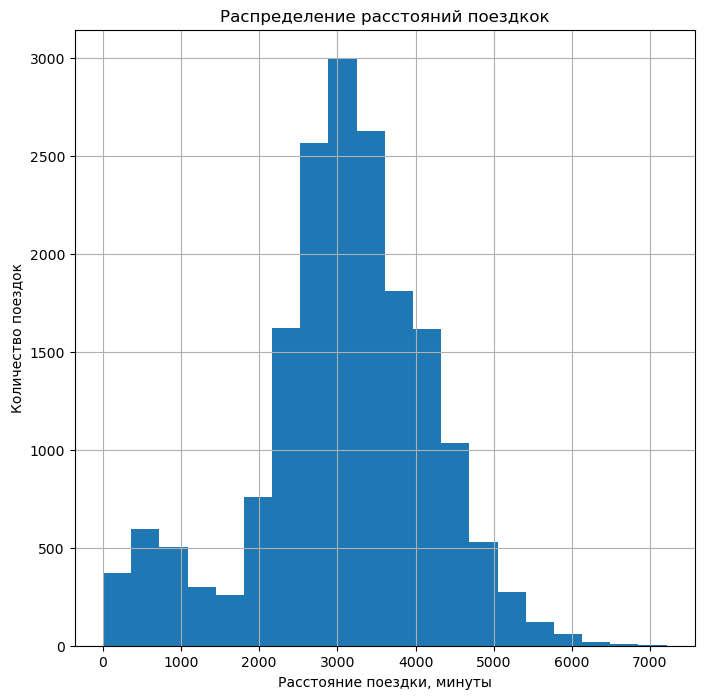

In [53]:
rides_go['distance'].hist(bins=20, figsize=(8,8)) 
plt.title('Распределение расстояний поездкок')
plt.xlabel('Расстояние поездки, минуты')
plt.ylabel('Количество поездок')

<Axes: >

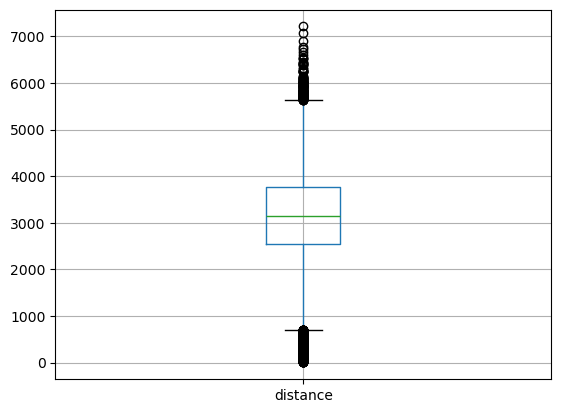

In [54]:
rides_go.boxplot('distance')

В оновном, пользователь используют самокаты для поездки на 3000 м. Очень редко на 6000 м и более. Гистограмма имеет вид нормального распределения с небольшим пиком от 0 до 1000 м.

#### Продолжительность поездок.

In [57]:
rides_go['duration'].describe()

count   18068.00
mean       17.81
std         6.09
min         0.50
25%        13.60
50%        17.68
75%        21.72
max        40.82
Name: duration, dtype: float64

In [58]:
# Самые короткие поездки
rides_go.sort_values('duration').head(10)

,user_id,distance,duration,date,month
12013,1102,4602.12,0.50,2021-08-01,8
17314,1483,4445.48,0.50,2021-03-06,3
15029,1318,5894.63,0.50,2021-03-28,3
7437,766,4539.09,0.50,2021-12-22,12
12967,1172,4907.14,0.50,2021-12-19,12
15015,1317,4593.39,0.50,2021-07-16,7
13012,1176,4935.07,0.50,2021-05-14,5
7508,772,4718.82,0.50,2021-05-22,5
16589,1428,5059.19,0.50,2021-05-06,5
9049,890,4848.49,0.50,2021-11-20,11


В данных присутствует аномалия. Некоторые пользователи за пол минуты расстояние более 4 км. Это может быть связано со сбоем в работе программы по расчету времени поездки. Компании необходимо выяснить, из-за чего произошел сбой, так как стоимость поездки зависит от времени и компания недополучать выручку.

(0.0, 45.0)

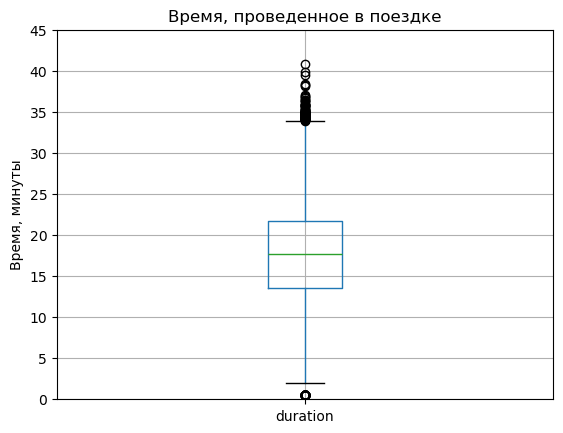

In [60]:
# Построим диаграмму размаха
rides_go.boxplot('duration')
plt.title('Время, проведенное в поездке')
plt.ylabel('Время, минуты')
plt.ylim(0, 45)

In [61]:
# Посчитаем число поездок, которые находятся ниже минимального заначения,не являющееся выбросом
q1 = rides_go['duration'].quantile(.25) # первый квартиль Q1
q3 = rides_go['duration'].quantile(.75) # третий квартиль Q3
iqr = q3 - q1 # межквартильный размах IQR
min_value = q1 - 1.5 * iqr
sort_lover_min_value = rides_go[rides_go['duration'] < min_value]
print(sort_lover_min_value['duration'].count())
len(sort_lover_min_value) / rides_go['duration'].count()

95


0.005257914545052026

Такие значения встречаются очень редко, но компании стоит обратить на это внимание.

In [63]:
# Соединим таблицы sort_lover_min_value и user_go, чтобы проанализировать аномальные значения
an_values = sort_lover_min_value.merge(user_go)
len(an_values)

95

In [64]:
an_values

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,701,4196.45,0.50,2021-08-31,8,Иван,31,Екатеринбург,free
1,704,4830.82,0.50,2021-10-14,10,Мирон,29,Ростов-на-Дону,free
2,712,4684.00,0.50,2021-03-04,3,Дарья,28,Москва,free
3,713,5215.64,0.50,2021-02-25,2,Святослав,30,Краснодар,free
4,718,5197.44,0.50,2021-02-11,2,Владислава,31,Москва,free
...,...,...,...,...,...,...,...,...,...
90,1460,5531.34,0.50,2021-01-19,1,Жанна,27,Пятигорск,free
91,1477,6724.93,0.50,2021-01-12,1,Ян,17,Сочи,free
92,1483,4445.48,0.50,2021-03-06,3,Роберт,26,Екатеринбург,free
93,1496,5722.55,0.50,2021-02-14,2,Яна,19,Москва,free


Проанализируе разные показатели таблицы и попытаемся найти закономерность.

In [66]:
an_values['subscription_type'].value_counts()

subscription_type
free    95
Name: count, dtype: int64

In [67]:
an_values['city'].value_counts()

city
Ростов-на-Дону    17
Москва            14
Пятигорск         13
Омск              11
Сочи              11
Краснодар         10
Тюмень            10
Екатеринбург       9
Name: count, dtype: int64

In [68]:
an_values['month'].value_counts()

month
3     11
12    11
11    11
1      9
8      8
2      8
5      8
4      7
7      7
9      6
6      5
10     4
Name: count, dtype: int64

In [69]:
an_values['user_id'].value_counts().head(10)

user_id
1364    2
1007    2
973     2
1243    2
1224    2
701     1
1217    1
1287    1
1285    1
1273    1
Name: count, dtype: int64

**Вывод:** сбои происходят только с пользователями без подписки, он не зависит от города и встречается примерно в равных количествах, происходит у разных пользователей.

In [71]:
# Самые длинные поездки
rides_go.sort_values('duration', ascending=False).head(10)

,user_id,distance,duration,date,month
4215,454,5137.33,40.82,2021-12-27,12
4709,507,4645.64,39.87,2021-01-15,1
2623,278,4754.43,39.53,2021-12-02,12
1998,216,4831.34,38.35,2021-05-11,5
6453,694,4210.87,38.27,2021-03-11,3
143,15,4187.62,38.13,2021-01-13,1
3729,401,4002.36,37.01,2021-09-21,9
499,55,4151.08,36.91,2021-06-30,6
6348,681,4134.88,36.81,2021-05-01,5
4653,501,4103.77,36.62,2021-05-24,5


Text(0, 0.5, 'Количество поездок')

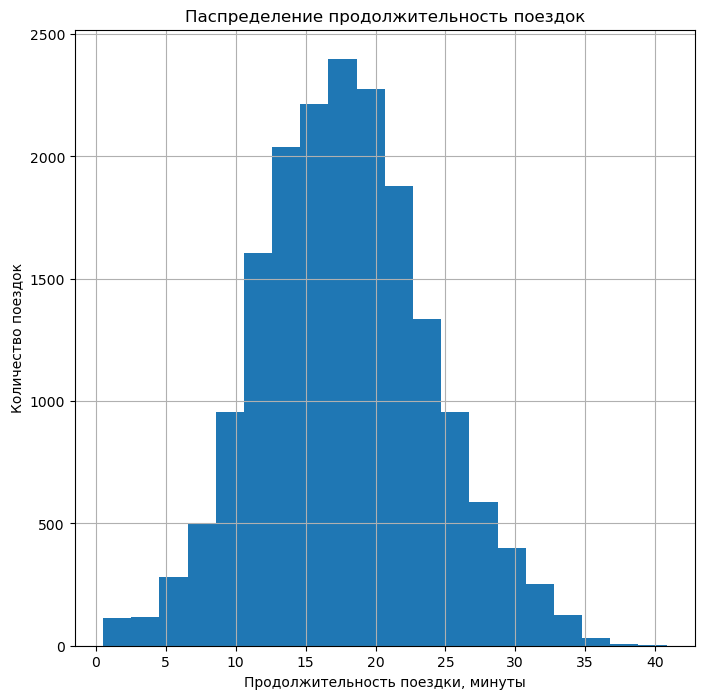

In [72]:
rides_go['duration'].hist(bins=20, figsize=(8,8)) 
plt.title('Паспределение продолжительность поездок')
plt.xlabel('Продолжительность поездки, минуты')
plt.ylabel('Количество поездок')

Продолжительность поздки в среднем - 18 минут. Поездки 35 минут и более встречаются редко. Гистограмма имеет вид нормального распределения.

**Вывод:**
- приложением больше всего используют в Пятигорске (219) и Екатеринбугре(204). Меньше всего в Москве(168).
- пользователей без подписки больше (835 или 54%). Пользователей с подпиской 699 или 46%;
- самый младший пользователь - 12 лет. Самый старший пользователь - 43 года. Средний возраст - 25 лет. Больше всего пользователей возраста 21 - 27 лет. Клиенты возрастом после 37 лет встречаются редко;
- в оновном пользователь используют самокаты для поездки на 3000 м. Присутствуют аномальные значения. Некоторые пользователи проезжали очень малое расстояние за большой промежуток времени. ;
- продолжительность поздки в среднем - 18 минут. В данных присутствует аномалия. Некоторые пользователи за пол минуты расстояние более 4 км.

### Шаг 4. Объединение данных

#### Объеденим  данные о пользователях, поездках и подписках в один датафрейм. 

In [77]:
full_data = user_go.merge(rides_go)
full_data = full_data.merge(sub_go)
full_data.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.89,16.65,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.02,14.93,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.12,23.12,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.69,15.24,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.69,15.04,2021-11-22,11,6,0,199


In [78]:
len(full_data) == len(rides_go)

True

In [79]:
full_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Размерs таблиц до и после объединения равны, а также отсутствуют пропуски. Значит присутствует информация о каждом пользователе в таблице rides_go.

#### Создадим датафрейм о пользователях без подписки

In [82]:
data_no_sub = full_data.query("subscription_type == 'free'")
data_no_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.94,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.23,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.02,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.78,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.43,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.82,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.41,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.44,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.67,2021-11-27,11,8,50,0


In [83]:
data_no_sub.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### Создадим датафрейм о пользователях c подпиской

In [85]:
data_sub = full_data.query("subscription_type == 'ultra'")
data_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.05,24.67,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.70,15.89,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.16,14.39,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.85,15.84,2021-10-17,10,6,0,199


In [86]:
data_sub.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

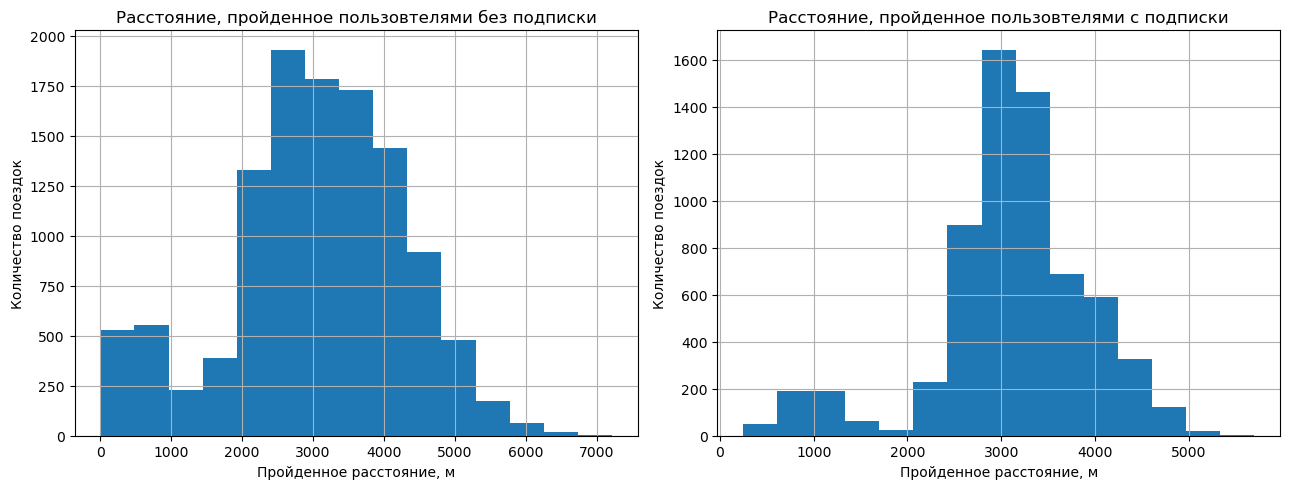

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
data_no_sub['distance'].hist(bins=15, ax=axes[0])
data_sub['distance'].hist(bins=15, ax=axes[1])
axes[0].set_title('Расстояние, пройденное пользовтелями без подписки')
axes[1].set_title('Расстояние, пройденное пользовтелями с подписки')
axes[0].set_ylabel('Количество поездок')
axes[1].set_ylabel('Количество поездок')
axes[0].set_xlabel('Пройденное расстояние, м')
axes[1].set_xlabel('Пройденное расстояние, м')
plt.tight_layout()

Text(0.5, 1.0, 'Время, затраченное пользовтелями без подпиской')

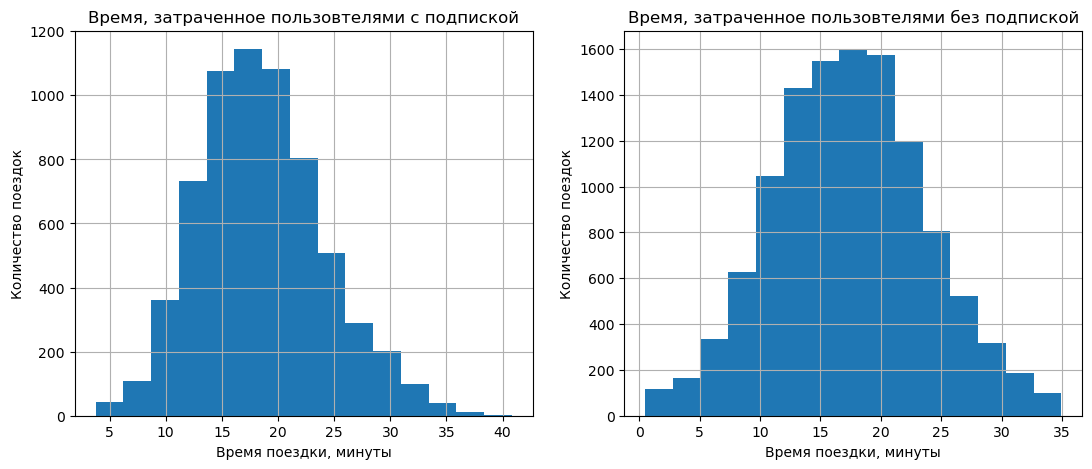

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
data_no_sub['duration'].hist(bins=15, ax=axes[1])
plt.title('Время, затраченное пользовтелями без подписки')
data_sub['duration'].hist(bins=15, ax=axes[0])
plt.title('Расстояние, пройденное пользовтелями с подписки')
axes[0].set_ylabel('Количество поездок')
axes[1].set_ylabel('Количество поездок')
axes[0].set_xlabel('Время поездки, минуты')
axes[1].set_xlabel('Время поездки, минуты')
axes[0].set_title('Время, затраченное пользовтелями с подпиской')
axes[1].set_title('Время, затраченное пользовтелями без подпиской')

Пользователи без подписки в основное проезжают 2500 м и затрачивают 18-21 минуты на поездки.

Пользователи с подпиской, как правило, проезжают 3000 м и затрачивают от 15 до 21 минуты.

In [92]:
data_no_sub[['age', 'distance', 'duration']].describe()

,age,distance,duration
count,11568.00,11568.00,11568.00
mean,24.89,3045.50,17.39
std,4.48,1246.17,6.33
min,12.00,0.86,0.50
25%,22.00,2366.56,12.96
50%,25.00,3114.65,17.33
75%,28.00,3905.70,21.59
max,43.00,7211.01,34.95


In [93]:
data_sub[['age', 'distance', 'duration']].describe()

,age,distance,duration
count,6500.00,6500.00,6500.00
mean,24.89,3115.45,18.54
std,4.76,836.90,5.57
min,12.00,244.21,3.76
25%,22.00,2785.44,14.52
50%,25.00,3148.64,18.18
75%,28.00,3560.57,21.88
max,38.00,5699.77,40.82


**Вывод:**
- объединили 3 таблицы в 1 под названием full_data;
- создали еще 2 таблицы на основе наличия у пользователя подписки;
- выяснили, что пользователи с подпиской проезжают бОльшее расстояние в сравнении с пользователями без подписки. При этом затрачивают примерно равное время на поездку.
- статистика двух таблиц похожа: они имеют одинаковый возраст пользователей, небольшое отлицие средней дистанции, но это из-за того, что таблица о пользователях без подписки имеют больше значений от 0-1000м. Разница среднего времени 1 минута в пользу пользователей с подпиской.

### Шаг 5. Подсчёт выручки

#### Создим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными 

In [97]:
# Округлим продолжительность поездки
full_data['duration'] = np.ceil(full_data['duration'])
# Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц
data_agg = full_data.pivot_table(index=['month', 'user_id'], values=['distance', 'duration', 'name', 'subscription_type'], 
                                 aggfunc={'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len,
                                      'subscription_type' : min})
data_agg.rename(columns={'name': 'count'}, inplace = True)
data_agg.head(10)

distance  duration  count subscription_type
month user_id                                             
1     1         7027.51     42.00      2             ultra
      3         3061.78     13.00      1             ultra
      5         3914.65     13.00      1             ultra
      7         6478.08     28.00      2             ultra
      12        3577.15     33.00      1             ultra
      13        6687.99     42.00      2             ultra
      14        7699.64     35.00      2             ultra
      15        4187.62     39.00      1             ultra
      20        3516.72     29.00      1             ultra
      22        3058.69     13.00      1             ultra

In [98]:
data_agg.isna().sum()

distance             0
duration             0
count                0
subscription_type    0
dtype: int64

#### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [100]:
def revenue_func(row):
    """
    Данная функция рассчитывает помесячную выручку с каждого пользователя в зависимости от наличия подписки
    """
    if row['subscription_type'] == 'ultra':
        return sub_go.loc[1, 'subscription_fee'] + row['duration'] * sub_go.loc[1, 'minute_price']
    elif row['subscription_type'] == 'free':
        return sub_go.loc[0, 'start_ride_price'] * row['count'] + row['duration'] * sub_go.loc[0, 'minute_price']
    else:
        return 'Отсутствуют данные о подписке'

In [101]:
data_agg['revenue_month'] = data_agg.apply(revenue_func, axis=1)
data_agg

distance  duration  count subscription_type  revenue_month
month user_id                                                            
1     1         7027.51     42.00      2             ultra         451.00
      3         3061.78     13.00      1             ultra         277.00
      5         3914.65     13.00      1             ultra         277.00
      7         6478.08     28.00      2             ultra         367.00
      12        3577.15     33.00      1             ultra         397.00
...                 ...       ...    ...               ...            ...
12    1525      4597.85     34.00      1              free         322.00
      1526      3644.12     23.00      1              free         234.00
      1528      3998.57     11.00      1              free         138.00
      1532      6111.89     42.00      2              free         436.00
      1534      2371.71     16.00      1              free         178.00

[11331 rows x 5 columns]

In [102]:
# Проверим, какая группа пользоветей приносит больше доходов
print(data_agg.groupby('subscription_type')['revenue_month'].sum())
print('Общий доход:', data_agg['revenue_month'].sum())

subscription_type
free    2234104.00
ultra   1644537.00
Name: revenue_month, dtype: float64
Общий доход: 3878641.0


In [103]:
print(data_agg.groupby(['month', 'subscription_type'])['revenue_month'].sum())

month  subscription_type
1      free                193850.00
       ultra               144108.00
2      free                165856.00
       ultra               124572.00
3      free                187214.00
       ultra               142608.00
4      free                185598.00
       ultra               137318.00
5      free                188030.00
       ultra               149235.00
6      free                192144.00
       ultra               143834.00
7      free                185038.00
       ultra               143466.00
8      free                187116.00
       ultra               138534.00
9      free                193700.00
       ultra               129337.00
10     free                181428.00
       ultra               133932.00
11     free                179076.00
       ultra               126546.00
12     free                195054.00
       ultra               131047.00
Name: revenue_month, dtype: float64


In [104]:
# Определим средний доход с пользователя в зависимости от подписки
print(data_agg.groupby('subscription_type')['revenue_month'].mean())

subscription_type
free    328.64
ultra   362.79
Name: revenue_month, dtype: float64


**Вывод:**
Создали новый датафрейм data_agg с агрегированными данными на основе таблицы full_data.
Написали функцию, которая определяет месячную выручку с каждого пользователя на основе наличия подписки или ее отсутствия. Пользователи с подпиской приносят меньше общего дохода, но средний доход с таких пользователй выше. Это связано с тем, что пользователей без подписки больше. Определили  доход с пользователей в зависимости от наличия подписки: годовой доход (ultra - 1644537 руб, free - 2234104 руб.), а также средний доход с пользователя (free - 328.64руб, ultra - 362.79 руб.)

### Шаг 6. Проверка гипотез

#### Пользователи с подпиской тратят больше времени на поездки.

H0: Время, затраченное пользователями по подписке ultra = время, затраченное пользователями по free

H1: Время, затраченное пользователями по подписке ultra > время, затраченное пользователями по free

In [109]:
# Проведем двухсторонний t-тест независимых выборок для проверки гипотезы
data_no_sub_dur = data_no_sub['duration']

data_sub_dur = data_sub['duration']


results = st.ttest_ind(data_sub_dur, 
                       data_no_sub_dur,
                       alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:** гипотезу о том, что пользователи с подпиской тратят больше времени на поездки, не отвергаем. Пользователи с подпиской будут выгодней для компании. Значение p очень маленькое, следоватьльно пользователи с подпиской почти всегда тратят больше времени на поездки.

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

H0: Среднее расстояние пользователей с подпиской ultra = 3130 метров

H1: Среднее расстояние пользователей с подпиской ultra > 3130 метров

In [113]:
data_sub_dist = data_sub['distance']

distance_optimal = 3130

results = st.ttest_1samp(
    data_sub_dist, 
    distance_optimal,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 
  

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод:** Гипотезу о том. что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, не отвергаем. Пользователи с подпиской выгодны, так как в среднем проезжают около 3130 м, что явлеяется оптимальным значением с точки зрения износа самоката. 

#### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

H0: помесячная выручка от пользователей с подпиской по месяцам = помесячная выручка от пользователей без подписки по месяца.

H1: Помесячная выручка от пользователей с подпиской по месяцам > помесячная выручка от пользователей без подписки.

In [117]:
data_agg_sub_rev = data_agg.loc[data_agg['subscription_type'] == 'ultra']['revenue_month']
data_agg_no_sub_rev = data_agg.loc[data_agg['subscription_type'] == 'free']['revenue_month']

results = st.ttest_ind(data_agg_sub_rev,
                      data_agg_no_sub_rev,
                      alternative = 'greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:** гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, не отвергаем. Следовательно, пользователи с подпиской выгоднее.

#### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Провести тест для проверки данной гипотизы. Какой тест вам понадобился бы для проверки этой гипотезы?

Необходимо провести двухсторонний тест для зависимых выборок, так как есть две таблицы: 1-ая до обращения и 2-я, измененная, после обновления приложения.
Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel().

Необходимо проверить одностороннюю гипотезу:

H0: число обращений после обновления = число обращений до обновления.

H1: число обращений после обновления > число обращений до обновления.

### Вывод

Провели исследоветельский анализ данных и выяснили:
- приложение больше всего используют в Пятигорске (219) и Екатеринбугре(204). Меньше всего в Москве(168).
- Пользователей без подписки больше (835 или 54%). Пользователей с подпиской 699 или 46%.
- Самый младший пользователь - 12 лет. Самый старший пользователь - 43 года. Средний возраст - 25 лет. Больше всего пользователей возраста 21 - 27 лет. Клиенты возрастом после 37 лет встречаются редко.
- В оновном пользователь используют самокаты для поездки на 3000 м. Присутствуют аномальные значения. Некоторые пользователи проезжали очень малое расстояние за большой промежуток времени.
- Продолжительность поздки в среднем - 18 минут. В данных присутствует аномалия. Некоторые пользователи за пол минуты расстояние более 4 км.

Определили доход с пользователей в зависимости от наличия подписки: годовой доход (ultra - 1644537 руб, free - 2234104 руб.), а также средний доход с пользователя (free - 328.64руб, ultra - 362.79).

Проверили выдвинутые гипотезы и определили:
- пользователи с подпиской тратят больше времени на поездки. Гипотезу не отвергаем.
- пользователи с подпиской примерно проезжают 3130 м в среднем. Гипотезу не отвергаем.
- выручка с пользоветелей с подпиской выше, чем с пользователей без подписки. Гипотезу не отвергаем.
- для проверки гипотезы о том, что после обновления сервера количество обращений в техподдержку снизится, необходимо провести двухсторонний тест для зависимых выборок.

Компании следует развивать и привлекать больше клиентов к покупке подписки, так как эти пользователи на 1 человека в среднем приносят больше выручки, тратят больше времени на поездки, проезжают в среднем 3130м, что является оптимальным значением для износа самоката.